# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
I received this box with great anticipation since they don't sell these on the west coast. I got the package, opened the box and was EXTREMELY disappointed. The cookies looked like a gorilla shook the box to death and left most of the box filled with crumbs. AND THERE WAS A RODENT SIZED HOLE ON THE SIDE OF THE BOX!!!!!!!! So, needless to say I will not NOT be reordering these again.
I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.
I was always a fan of Dave's, so I bought this at a local store to try Blair's and I'm glad I did.  The jalepeno saus

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I have two cats. My big boy has eaten these and never had a problem...as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months. My girl cat throws up every time she eats this particular flavor. Since I treat them equally these are no longer purchased. I hate to see my girl sick so I just recommend you watch your cats after you give them these treats. If not a problem...carry on.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I have two cats My big boy has eaten these and never had a problem as a matter of fact he has never vomited or had a hair ball since I adopted him at 2 months My girl cat throws up every time she eats this particular flavor Since I treat them equally these are no longer purchased I hate to see my girl sick so I just recommend you watch your cats after you give them these treats If not a problem carry on 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 19354/19354 [00:06<00:00, 2769.11it/s]


In [23]:
preprocessed_reviews[1500]

'two cats big boy eaten never problem matter fact never vomited hair ball since adopted months girl cat throws every time eats particular flavor since treat equally no longer purchased hate see girl sick recommend watch cats give treats not problem carry'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aaaaa', 'aaaand', 'aafco', 'aahhhs', 'aahs', 'ab', 'aback', 'abandon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 25997)
the number of unique words  25997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (19354, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able give', 'able make', 'able order', 'able purchase']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (19354, 11762)
the number of unique words including both unigrams and bigrams  11762


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('good', 0.7953426837921143), ('fantastic', 0.787317156791687), ('awesome', 0.7811514139175415), ('excellent', 0.7790090441703796), ('wonderful', 0.7586983442306519), ('amazing', 0.7489418387413025), ('delicious', 0.6821162104606628), ('perfect', 0.6787960529327393), ('love', 0.662926971912384), ('decent', 0.6582112312316895)]
[('closest', 0.830569326877594), ('world', 0.7922364473342896), ('personal', 0.7887846231460571), ('best', 0.7801730632781982), ('bye', 0.7778558731079102), ('jamaica', 0.7738444805145264), ('ever', 0.7732053399085999), ('disappointing', 0.7717299461364746), ('hooked', 0.7690412402153015), ('britt', 0.7629915475845337)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8370
sample words  ['used', 'fly', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'product', 'available', 'traps', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'really', 'good', 'idea', 'final', 'outstanding', 'use', 'car', 'window', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'reverse', 'windows', 'beautifully']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 19354/19354 [00:26<00:00, 740.55it/s]


19354
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|███████████████████████████████████| 19354/19354 [02:57<00:00, 109.06it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

### Data extraction for Analysis

In [34]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [35]:
df = filtered_data.iloc[:,lambda df:[9,6]].copy()
print(df.head(3))
print(df.shape)
print(df['Text'].values[10])

                                                Text  Score
0  I have bought several of the Vitality canned d...      1
1  Product arrived labeled as Jumbo Salted Peanut...      0
2  This is a confection that has been around a fe...      1
(20000, 2)
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the

In [36]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 20000/20000 [00:06<00:00, 2989.52it/s]


In [37]:
df['Text'] = preprocessed_reviews
df.head(5)
print(df['Text'].values[10])
print("=="*40)
print(df.shape)

not know cactus tequila unique combination ingredients flavour hot sauce makes one kind picked bottle trip brought back home us totally blown away realized simply could not find anywhere city bummed magic internet case sauce ecstatic love hot sauce mean really love hot sauce not want sauce tastelessly burns throat grab bottle tequila picante gourmet de inclan realize taste never want use sauce thank personal incredible service
(20000, 2)


### Spliting the Data for Train, CV, and Test

In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

X = np.array(df.iloc[:,0])
Y = np.array(df['Score'])
class_names = ['Positive','Negative']
print(X.shape)
print(Y.shape)
print("="*100)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase)# this is for time series split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33) # this is random splitting
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)
print(class_names)

(20000,)
(20000,)
(8978,) (8978,)
(4422,) (4422,)
(6600,) (6600,)
['Positive', 'Negative']


# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

In [39]:
# Please write all the code with proper documentation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data
# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_cv_bow = vectorizer.transform(X_cv)
X_test_bow = vectorizer.transform(X_test)
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)
print(X_test_bow.shape, y_test.shape)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


After vectorizations
(8978, 18105) (8978,)
(4422, 18105) (4422,)
(6600, 18105) (6600,)


### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

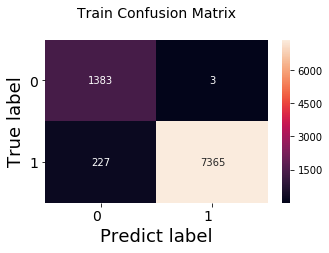

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


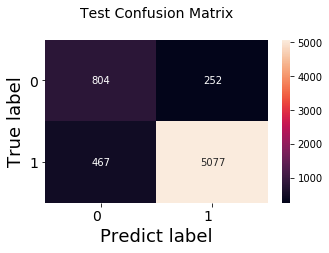

The AUC value for test data is  0.9178877007357121


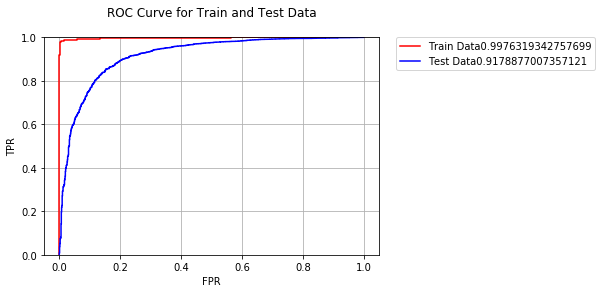

In [40]:
from sklearn. metrics import roc_auc_score
tuned_parameters = [{'C': [10**-4, 10**-2,10**-1, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight = 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_bow, y_train)
######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(X_train_bow))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
#######################################################################################################################
print(model.best_estimator_)

######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(X_test_bow))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()
#######################################################################################################################

pred_prob = model.predict_proba(X_test_bow)
pred_prob_train = model.predict_proba(X_train_bow)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r',label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [41]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=1,class_weight = 'balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False);
clf.fit(X_train_bow, y_train);
w = clf.coef_
print(np.count_nonzero(w))


1294


In [42]:
clf = LogisticRegression(C=1,class_weight = 'balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False);
clf.fit(X_train_bow, y_train);
w = clf.coef_
print(np.count_nonzero(w))


18105


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.940156905674147
The AUC value for test data is  0.9223359303259872


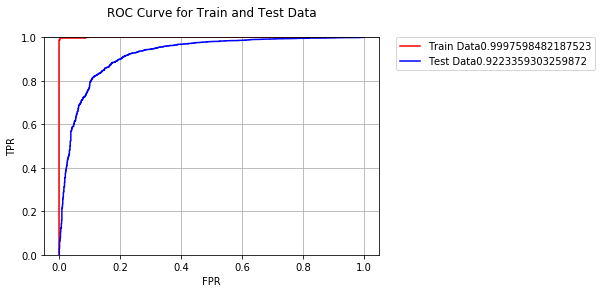

In [43]:
# Please write all the code with proper documentation
model = GridSearchCV(LogisticRegression(penalty='l2',class_weight = 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_bow, y_train)

print(model.best_estimator_)
print(model.score(X_test_bow, y_test))
y_pred = model.best_estimator_.predict(X_test_bow)
from sklearn.metrics import confusion_matrix

pred_prob = model.predict_proba(X_test_bow)
pred_prob_train = model.predict_proba(X_train_bow)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r',label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()



#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [52]:
model1 = LogisticRegression(C=1, class_weight= 'balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
model1.fit(X_train_bow, y_train)
print(type(X_train_bow))
w = model1.coef_
X_train_bow_new = X_train_bow + np.random.uniform(-0.0001,0.0001,1)
model1.fit(X_train_bow_new, y_train)
w1 = model1.coef_

w += 10**-6
w1 += 10**-6

percentage_change_vector = abs( (w-w1) / (w) )*100
print(percentage_change_vector.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(1, 18105)


0 th percentile :  2.602853155207496e-07
10 th percentile :  0.004740563859555994
20 th percentile :  0.011841549306730982
30 th percentile :  0.022055286176526565
40 th percentile :  0.039593377700132375
50 th percentile :  0.07187585794097924
60 th percentile :  0.14844762655902655
70 th percentile :  0.41598330482532214
80 th percentile :  2.5742169999871765
90 th percentile :  74.4316109229945
100 th percentile :  95881.5106031805


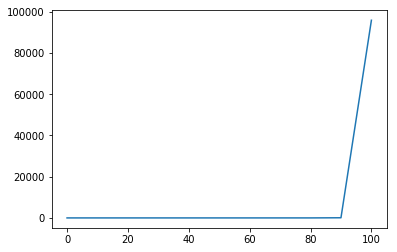

In [45]:
k = range(0,101,10)
for i in k:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(k,np.percentile(percentage_change_vector,k) )


90 th percentile :  74.4316109229945
91 th percentile :  135.82212361095935
92 th percentile :  188.46706435087907
93 th percentile :  335.5829031555748
94 th percentile :  729.4691953570778
95 th percentile :  1127.7626815361098
96 th percentile :  2004.5327915163614
97 th percentile :  3507.882796464326
98 th percentile :  4746.350463800848
99 th percentile :  6742.089947295662
100 th percentile :  95881.5106031805


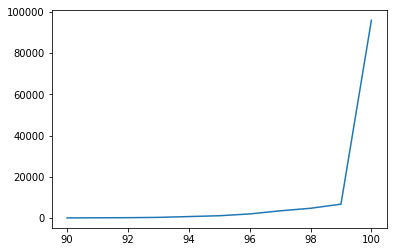

In [46]:
r = range(90,101,1)
for i in r:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(r,np.percentile(percentage_change_vector,r) )


99.0 th percentile :  6742.089947295662
99.11111111111111 th percentile :  7070.922691297142
99.22222222222223 th percentile :  7506.113206451113
99.33333333333333 th percentile :  7884.921751619444
99.44444444444444 th percentile :  8809.489864737543
99.55555555555556 th percentile :  9951.731805963316
99.66666666666667 th percentile :  13480.837552423636
99.77777777777777 th percentile :  17636.69497745442
99.88888888888889 th percentile :  21271.238542512154
100.0 th percentile :  95881.5106031805


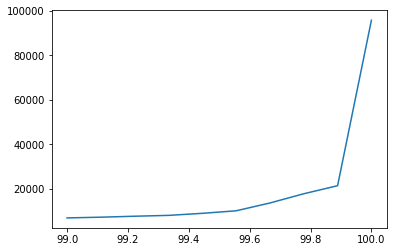

In [47]:

t = np.linspace(99,100,10)
for i in t:
    print(i, "th percentile : ",np.percentile(percentage_change_vector,i))

plt.plot(t,np.percentile(percentage_change_vector,t) )

In [59]:
# Please write all the code with proper documentation
count_v = CountVectorizer()
j = count_v.fit_transform(X_train)
srv = pd.DataFrame(percentage_change_vector.T,columns=['percent change'])
srv['features'] = count_v.get_feature_names()
print(srv.shape,'\n')
k = srv.sort_values(by = 'percent change',kind = 'quicksort',ascending= True)
print(k.tail(5))

(18105, 2) 

       percent change   features
17672    46856.685900    whirley
2644     54747.197914     chevre
10795    67212.518895       oaty
564      67212.518895    analogy
4229     83559.149252  departure


In [66]:
mpc = srv.loc[srv['percent change'] >= 2.5,['features','percent change']]
mpc = mpc.sort_values(by = 'percent change',kind = 'quicksort',ascending= True)
print(mpc.head(5))

        features  percent change
12621    puroast        2.500811
8442          jb        2.503112
2889      cleans        2.503873
5372   erstwhile        2.505060
9942     milkier        2.510841


In [77]:
print("The features which has % change more than 2.5%\n",mpc['features'])

The features which has % change more than 2.5%
 12621         puroast
8442               jb
2889           cleans
5372        erstwhile
9942          milkier
4955            duper
640             antic
8920         lavazzas
11781       pienaroma
8019        indulgent
3947              dan
6038            flair
15079        spreader
14902    southwestern
9385         lundberg
4751          donates
11711      phenomenon
5725         faintest
2894          cleanup
3106        combining
13983           scour
2908             cleo
1387         benifits
198           adjunct
2001              bug
3738             crip
1622        bluegrass
17070           urges
9547           mapley
13879           sause
             ...     
10627         nonstop
17955             yak
16149           theor
1358          bellies
10770       nutritous
1713         borleans
161         adaptable
1153          banging
4292          despise
17633           whack
3478          coolish
7003         greening
15104 

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [78]:
feat_log = w
print(w.shape)
print("=="*25)
count_vect = CountVectorizer()
p = count_vect.fit_transform(X_train)
p = pd.DataFrame(feat_log.T,columns=['+ve'])
p['feature'] = count_vect.get_feature_names()
print(p.head(5))
print("=="*25)
print(p.shape)

(1, 18105)
            +ve feature
0 -2.202862e-01      aa
1  2.835442e-02    aaaa
2  6.699515e-07   aafco
3  1.274229e-04  aahhhs
4  3.860262e-05      ab
(18105, 2)


In [79]:
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)
print("Top 10  important features of positive class", np.array(q['feature'][:10]))

Top 10  important features of positive class ['excellent' 'pleased' 'smooth' 'delicious' 'highly' 'loves' 'perfect'
 'wonderful' 'awesome' 'difference']


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [80]:
# Please write all the code with proper documentation
print("Top 10  important features of negative class",np.array(q.tail(10)['feature']))

Top 10  important features of negative class ['horrible' 'weak' 'china' 'unfortunately' 'vomiting' 'disappointed'
 'tasteless' 'yuck' 'worst' 'terrible']


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

In [81]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf.fit(X_train)
X_train_tf_idf = tf_idf.transform(X_train)
X_cv_tf_idf = tf_idf.transform(X_cv)
X_test_tf_idf = tf_idf.transform(X_test)
print("After vectorizations")
print(X_train_tf_idf.shape, y_train.shape)
print(X_cv_tf_idf.shape, y_cv.shape)
print(X_test_tf_idf.shape, y_test.shape)

After vectorizations
(8978, 5581) (8978,)
(4422, 5581) (4422,)
(6600, 5581) (6600,)


### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

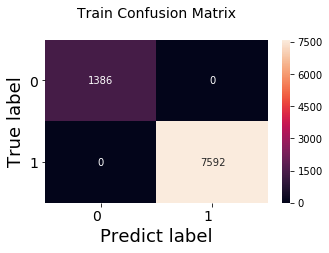

LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


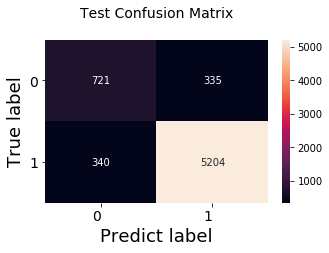

The AUC value for test data is  0.9180134167705191


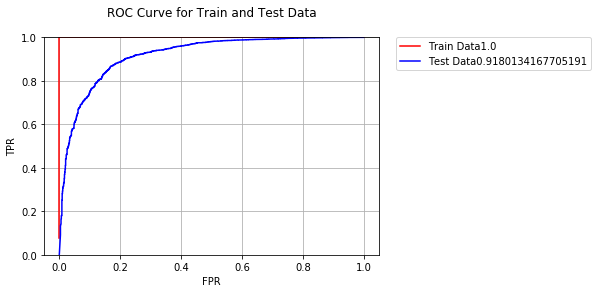

In [82]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight= 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_tf_idf, y_train)


######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(X_train_tf_idf))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
#######################################################################################################################
print(model.best_estimator_)

######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(X_test_tf_idf))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()
#######################################################################################################################
pred_prob = model.predict_proba(X_test_tf_idf)
pred_prob_train = model.predict_proba(X_train_tf_idf)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r', label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


In [83]:
# Please write all the code with proper documentation
tf_idf = LogisticRegression(C=1, class_weight= 'balanced' , dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
tf_idf.fit(X_test_tf_idf,y_test)

tf_idf_weight = tf_idf.coef_
print(tf_idf_weight.shape)


(1, 5581)


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The AUC value for test data is  0.9308135638036207


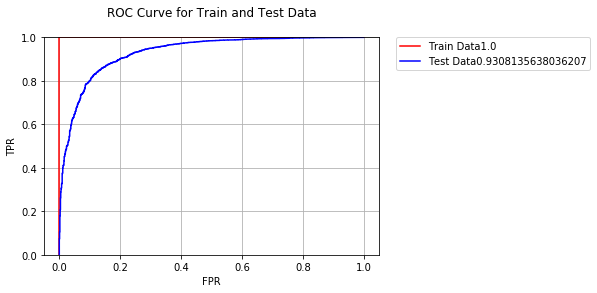

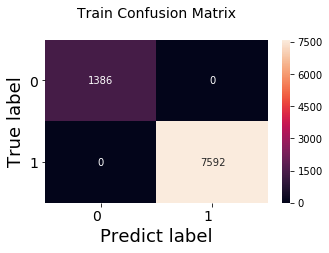

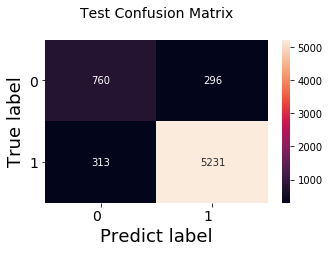

In [84]:
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2',class_weight= 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(X_train_tf_idf, y_train)
print(model.best_estimator_)

pred_prob = model.predict_proba(X_test_tf_idf)
pred_prob_train = model.predict_proba(X_train_tf_idf)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r', label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(X_train_tf_idf))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(X_test_tf_idf))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()

In [85]:
tf_idf_l2 = LogisticRegression(C=100, class_weight= 'balanced', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
tf_idf_l2.fit(X_test_tf_idf,y_test)
l2w = tf_idf_l2.coef_
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
p = tf_idf_vect.fit_transform(X_train)
p = pd.DataFrame(l2w.T,columns=['+ve'])
p['feature'] = tf_idf_vect.get_feature_names()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [86]:
# Please write all the code with proper documentation
q = p.sort_values(by = '+ve',kind = 'quicksort',ascending= False)

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [87]:
print("Top 10  important features of positive class", np.array(q['feature'][:10]))

Top 10  important features of positive class ['good' 'great' 'best' 'love' 'nice' 'wonderful' 'delicious' 'perfect'
 'not disappointed' 'supply']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [88]:
# Please write all the code with proper documentation
print("Top 10  important features of negative class",np.array(q.tail(10)['feature']))

Top 10  important features of negative class ['would good' 'nasty' 'hoping' 'horrible' 'not' 'ended' 'disappointed'
 'disappointing' 'died' 'awful']


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

In [89]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    

In [90]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

In [91]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5669
sample words  ['really', 'help', 'father', 'cancer', 'patient', 'didnt', 'want', 'eat', 'taste', 'no', 'good', 'well', 'miracle', 'berry', 'gave', 'avoid', 'products', 'artificial', 'sweeteners', 'includes', 'sodas', 'high', 'fructose', 'corn', 'syrup', 'switch', 'line', 'fruit', 'juice', 'added', 'not', 'even', 'cane', 'sugar', 'carbonated', 'water', 'natural', 'flavors', 'colors', 'vitamin', 'c', 'going', 'drink', 'soda', 'best', 'way', 'go', 'several', 'including', 'orange']


In [92]:
from tqdm import tqdm
import numpy as np

# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|█████████████████████████████████████| 8978/8978 [00:09<00:00, 972.01it/s]


(8978, 50)
[ 0.05188777 -0.13533611  0.04357306  0.00161339  0.21219997  0.48863844
 -0.64742523 -0.16267104  0.353654    0.26179667  0.31231967  0.2216405
 -0.44580151 -0.48718375 -0.47087024 -0.31587079  0.44553032  0.07882028
  0.30502673  0.19089566  0.09821041  0.15326672 -0.41123067 -0.50657919
 -0.10760824  0.21014725  0.5864309   0.71206714 -0.12176617  0.52007331
  0.06396975 -0.14695047 -0.51032525 -0.72563693  0.1551665  -0.48134402
 -0.41463272 -0.26652807 -0.95692927 -0.29494003 -0.18790874  0.04444034
 -0.07506789  0.11403142 -0.02634232 -0.36212559 -0.13313351 -0.9275926
  0.6063497   0.05970301]


## CV Data

In [93]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [94]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|█████████████████████████████████████| 4422/4422 [00:04<00:00, 953.41it/s]


(4422, 50)
[ 0.11884634  0.029407   -0.07181826 -0.05499787  0.30613991  0.33585469
 -0.64006896 -0.10450354  0.30104494  0.42411666  0.18425606  0.12266109
 -0.44561948 -0.48695748 -0.67083051 -0.35269842  0.57603683 -0.26521422
  0.31347826  0.35845126  0.05062236  0.11838009 -0.25427904 -0.50396278
 -0.09476658  0.17745968  0.68124681  0.48114511 -0.05965596  0.50535478
 -0.04663408 -0.33273421 -0.37346646 -0.69677737  0.29340904 -0.51979641
 -0.43796924 -0.39165983 -0.97425637 -0.07266514 -0.17852726  0.09837908
 -0.04784798 -0.06515889  0.0271996  -0.2868753  -0.35179722 -0.75155076
  0.41346574 -0.07809038]


## TEST data

In [95]:
i= 0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [96]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████| 6600/6600 [00:07<00:00, 912.75it/s]


(6600, 50)
[ 1.59808690e-02 -1.87802628e-01  1.91995068e-01 -9.62847873e-03
  1.25860703e-01  1.99263347e-01 -2.07358370e-01 -2.25372963e-01
  2.47622218e-01  2.74209234e-01  8.84352836e-02  3.59186370e-01
  1.05891573e-03 -8.27140473e-01 -5.98486640e-01 -3.84466789e-01
  5.91068319e-01 -3.74467761e-01  3.15138442e-01  2.02936942e-01
  4.62415969e-01  1.55719857e-01 -3.10157082e-01 -4.77906132e-01
  1.11207744e-02  3.95260292e-01  1.79750958e-01  1.15630430e+00
 -1.70151783e-01  6.30057072e-01  2.01131348e-01 -2.67101538e-01
 -9.16241679e-01 -7.59202088e-01  5.05332237e-01 -1.89466753e-01
 -4.99945625e-01 -4.91362160e-01 -4.73868194e-01  1.25291634e-02
 -3.02042226e-01  1.77783933e-01  1.62637337e-01  1.93702142e-01
  2.31286383e-01 -7.17137426e-01 -2.93094826e-01 -5.51569271e-01
  5.41521567e-01  3.16502090e-01]


### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The AUC value for test data is  0.8532196115647821


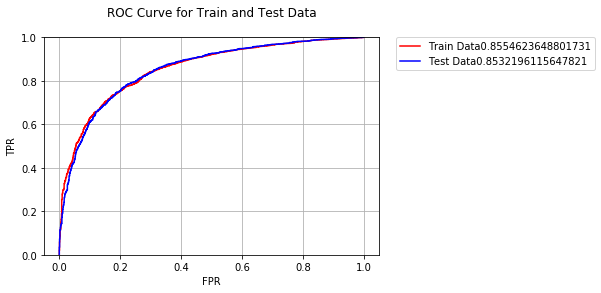

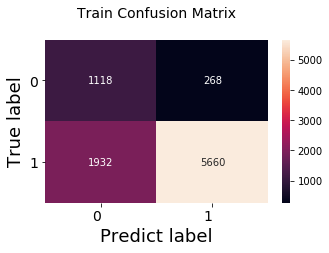

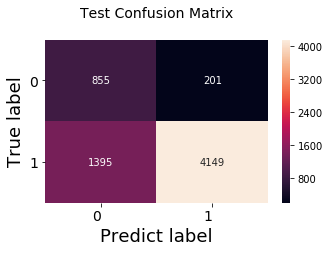

In [97]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight= 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(sent_vectors_train, y_train)
print(model.best_estimator_)

pred_prob = model.predict_proba(sent_vectors_test)
pred_prob_train = model.predict_proba(sent_vectors_train)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r', label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(sent_vectors_train))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The AUC value for test data is  0.6686136425127902


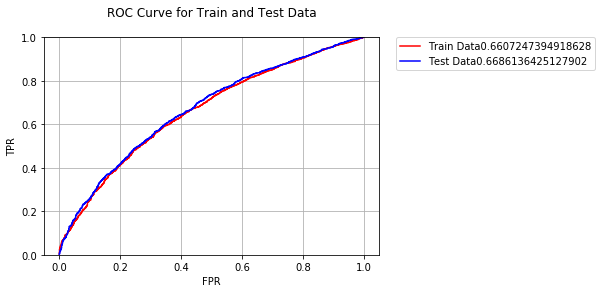

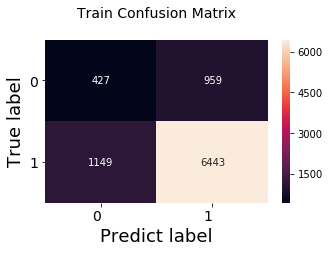

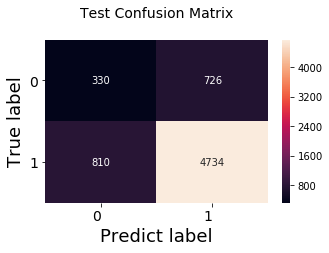

In [98]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2',class_weight= 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(sent_vectors_train, y_train)
print(model.best_estimator_)

pred_prob = model.predict_proba(sent_vectors_test)
pred_prob_train = model.predict_proba(sent_vectors_train)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r', label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(sent_vectors_train))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

In [99]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

### Train data

In [100]:
tfidf_feat = model.get_feature_names()
tfidf_sent_vectors = [];
i = 0;
list_of_sentence = []
for sentance in X_train:
    list_of_sentance.append(sentance.split())
    
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████| 8978/8978 [00:54<00:00, 163.92it/s]


### CV data

In [101]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
    
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
tfidf_cv_sent_vectors_cv = np.array(sent_vectors_cv)
print(tfidf_cv_sent_vectors_cv[0])

100%|█████████████████████████████████████| 4422/4422 [00:04<00:00, 980.56it/s]


[ 0.11884634  0.029407   -0.07181826 -0.05499787  0.30613991  0.33585469
 -0.64006896 -0.10450354  0.30104494  0.42411666  0.18425606  0.12266109
 -0.44561948 -0.48695748 -0.67083051 -0.35269842  0.57603683 -0.26521422
  0.31347826  0.35845126  0.05062236  0.11838009 -0.25427904 -0.50396278
 -0.09476658  0.17745968  0.68124681  0.48114511 -0.05965596  0.50535478
 -0.04663408 -0.33273421 -0.37346646 -0.69677737  0.29340904 -0.51979641
 -0.43796924 -0.39165983 -0.97425637 -0.07266514 -0.17852726  0.09837908
 -0.04784798 -0.06515889  0.0271996  -0.2868753  -0.35179722 -0.75155076
  0.41346574 -0.07809038]


### Test data

In [102]:
i= 0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [103]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
tfidf_test_sent_vectors_test = np.array(sent_vectors_test)
print(tfidf_test_sent_vectors_test[0])

100%|████████████████████████████████████| 6600/6600 [00:06<00:00, 1015.32it/s]


[ 1.59808690e-02 -1.87802628e-01  1.91995068e-01 -9.62847873e-03
  1.25860703e-01  1.99263347e-01 -2.07358370e-01 -2.25372963e-01
  2.47622218e-01  2.74209234e-01  8.84352836e-02  3.59186370e-01
  1.05891573e-03 -8.27140473e-01 -5.98486640e-01 -3.84466789e-01
  5.91068319e-01 -3.74467761e-01  3.15138442e-01  2.02936942e-01
  4.62415969e-01  1.55719857e-01 -3.10157082e-01 -4.77906132e-01
  1.11207744e-02  3.95260292e-01  1.79750958e-01  1.15630430e+00
 -1.70151783e-01  6.30057072e-01  2.01131348e-01 -2.67101538e-01
 -9.16241679e-01 -7.59202088e-01  5.05332237e-01 -1.89466753e-01
 -4.99945625e-01 -4.91362160e-01 -4.73868194e-01  1.25291634e-02
 -3.02042226e-01  1.77783933e-01  1.62637337e-01  1.93702142e-01
  2.31286383e-01 -7.17137426e-01 -2.93094826e-01 -5.51569271e-01
  5.41521567e-01  3.16502090e-01]


### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The AUC value for test data is  0.8525910313907472


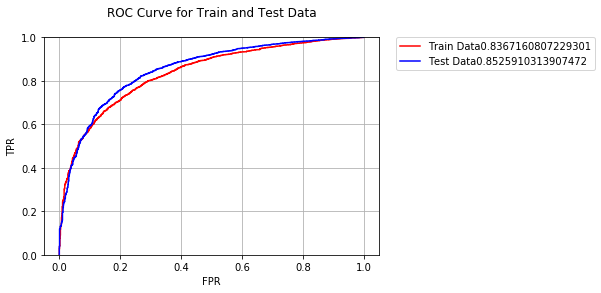

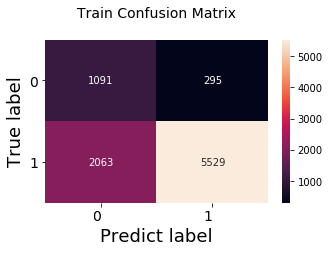

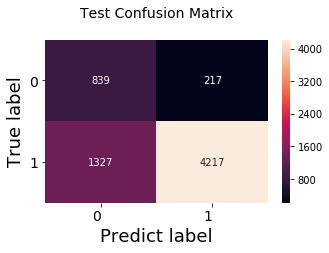

In [104]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l1',class_weight= 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(tfidf_sent_vectors, y_train)
print(model.best_estimator_)

pred_prob = model.predict_proba(tfidf_test_sent_vectors_test)
pred_prob_train = model.predict_proba(tfidf_sent_vectors)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r', label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(tfidf_sent_vectors))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

LogisticRegression(C=0.0001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
The AUC value for test data is  0.671579071969697


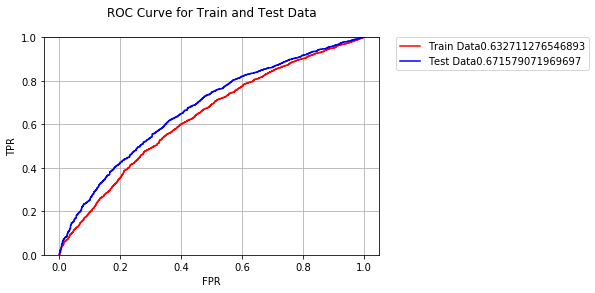

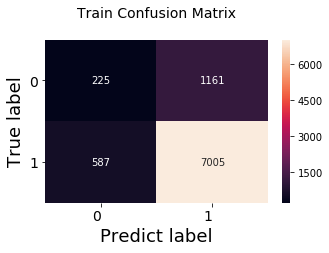

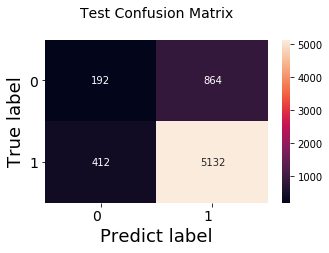

In [105]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(LogisticRegression(penalty='l2',class_weight= 'balanced'), tuned_parameters, scoring = 'f1', cv=5)
model.fit(tfidf_sent_vectors, y_train)
print(model.best_estimator_)

pred_prob = model.predict_proba(tfidf_test_sent_vectors_test)
pred_prob_train = model.predict_proba(tfidf_sent_vectors)

    #ROC Values comutation
fpr, tpr, threshold = roc_curve(y_train, pred_prob_train[:,1])
fpr1, tpr1, threshold1 = roc_curve(y_test, pred_prob[:,1])
print("The AUC value for test data is ",roc_auc_score(y_test, pred_prob[:,1]))
plt.plot(fpr,tpr,'r', label = 'Train Data'+str(auc(fpr,tpr)))
plt.plot(fpr1,tpr1,'b', label = 'Test Data'+str(auc(fpr1,tpr1)))
plt.ylim(0,1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.title("ROC Curve for Train and Test Data\n")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
######################################       confution matrix  Train      ############################################  
cm = confusion_matrix(y_train,model.predict(tfidf_sent_vectors))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Train Confusion Matrix\n",size=14)
plt.show()
######################################       confution matrix  Test      ############################################  
cm = confusion_matrix(y_test,model.predict(sent_vectors_test))
tn, fp, fn, tp = cm.ravel()
    # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    # Code for drawing seaborn heatmaps
class_names = ['0','1']
df_heatmap = pd.DataFrame(cm, index=class_names, columns=class_names )
fig = plt.figure(figsize=(5,3))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")
# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predict label',size=18)
plt.title("Test Confusion Matrix\n",size=14)
plt.show()

# [6] Conclusions

In [107]:
from prettytable import from_csv
fp = open("log.csv", "r")
mytable = from_csv(fp)
print(mytable)

+---------------+----------------+------------------+------+
| ï»¿Vectorizer | Regularization | Hyper perameters | AUC  |
+---------------+----------------+------------------+------+
|      BOW      |       L1       |        1         | 0.91 |
|      BOW      |       L2       |        1         | 0.92 |
|     TF-IDF    |       L1       |      10000       | 0.91 |
|     TF-IDF    |       L2       |       100        | 0.93 |
|   Avg w2vec   |       L1       |       100        | 0.85 |
|   Avg w2vec   |       L2       |      0.0001      | 0.66 |
|  TF-IDF W2vec |       L1       |       100        | 0.85 |
|  TF-IDF W2vec |       L2       |      0.0001      | 0.67 |
+---------------+----------------+------------------+------+


1) From the above model performence table it can be stated that, BoW and Tf-IDF performed eqaully

2) The other models like w2vec and Tf-Idf w2vec yealds less AUC value

3) The hyperperameters values changed drasticaly for  TF-IDF,w2vec and Tf-Idf w2vec , which says the loss funtion is not classifing the points better and it depends more on regularization to give just 0.85 AUC

4) Model which uses less c value means its overfitting and high c value means underfitting

5) When sparsity of 'L1' and 'L2' regularization is observed on BOW, we got more sparsity for L2 regularizer than the L1 regulrizer. but theoretically L1 regularization should have more sparsity than the L2, which need to be studied further.

6) since logistic regression takes more time to compute, we limited our observation to 20k data points